In [2]:
import numpy as np
import matplotlib.pyplot as plt

# start by loading the fasta file containing covid19 genome
genome = "".join(open("covid19.fasta","r").read().split("\n")[1:])

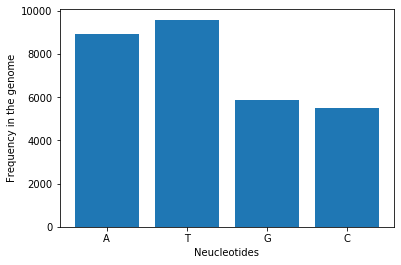

In [16]:
# How many of each neucleotides ?
from collections import Counter
neucleotide_freq = Counter(genome)

plt.bar(neucleotide_freq.keys(),neucleotide_freq.values())
plt.xlabel("Neucleotides")
plt.ylabel("Frequency in the genome")
plt.savefig("neucleotide_frequency.png",dpi=300)
plt.show()
plt.close()

let's search for start codon 'ATG'
 We shall use a non-trivial linear time search algorithm called Booyer-Moore search

In [17]:
!gcc boyer_moore.c -o boyer_moore; ./boyer_moore ATG covid19.fasta > ATG_occur.txt

In [19]:
#Let's open the output and see how many we found
!grep ^Total ATG_occur.txt

Total Matches found:	725


So, 725 is too many, all of them cannot possibly a start codon. (the virus expresses only a few proteins)
Search for the stop codons then ? TAG, TGA, TAA

In [21]:
!./boyer_moore TGA covid19.fasta > TGA_occur.txt 
!./boyer_moore TAG covid19.fasta > TAG_occur.txt
!./boyer_moore TAA covid19.fasta > TAA_occur.txt
!echo TGA; grep ^Total TGA_occur.txt
!echo TAG; grep ^Total TAG_occur.txt
!echo TAA; grep ^Total TAA_occur.txt

TGA
Total Matches found:	630
TAG
Total Matches found:	427
TAA
Total Matches found:	719


They also occur a lot many times ! 
All that is expected because triplets are highly likely to occur just by chance
So, let's look for ribosome binding site !

take sequences of length 50 before and after the ATG sites discovered earlier. Then we shall do a "motif search" among them. 'Motif's are similar non-random sequence that occur in genome which actsas a functional site (i.e. mainly protein binding site). A strong motif will give us candidate sites for start of translation in these cases. (i.e. start of the viral genes!!)



In [31]:
#just some necessary file processing
!grep ^match ATG_occur.txt | cut -d " " -f4 > ATG_matches.txt

In [60]:
window = 50
ATG_positions = [int(i) for i in open("ATG_matches.txt","r").read().split("\n")[:-1] if int(i) > window]

In [77]:
candidate_seqs_containing_motif = []
for pos in ATG_positions:   ## double loop, this is possible only becaue viral genome is small
    try:
        candidate_seqs_containing_motif.append(genome[pos - window:pos+3])
    except:
        pass
    

motif_length = 8
n_candidates = 10 #len(candidate_seqs_containing_motif)
f = open("candidate_seqs_containing_motifs.txt","w")
f.write(str(motif_length)+"\n")
f.write(str(n_candidates)+"\n")
f.write("\n".join(candidate_seqs_containing_motif))
f.close()

In [118]:
!cd java; java Main < ../candidate_seqs_containing_motifs.txt > ../best_motifs.txt; cat ../best_motifs.txt; cd ..

TCTGTTCT 
GCCGATCA 
TGGAGACT 
TGGCTTAG 
TGTGTTCA 
TGTGTTCA 
TGTGTTCA 
TGTGTTCA 
GGCATTCA 
GCCGATCT 


Now we got our top 10 possible motifs, Let's make a motif logo using this tool: https://weblogo.berkeley.edu/logo.cgi

In [125]:
#TGTGTTCA comes up multiple times !
#Let's search for it in the candidates to see where they came from
for i in candidate_seqs_containing_motif:
    if("GCCGATCA" in i):
        print(i)
        print("position of ATG for this occurence: ", ATG_positions[candidate_seqs_containing_motif.index(i)] + 1)


GCCGATCATCAGCACATCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATG
position of ATG for this occurence:  266


29903